In [1]:
import os
import sys
import torch
import glob
import csv
import pandas as pd
import numpy as np
import nilearn.datasets
import nilearn.connectome
import pathlib
from nilearn.input_data import NiftiMasker
from nilearn import datasets, plotting, image
from csv import writer

sys.path.append(os.path.join(".."))
sys.path.append('../src')
import gcn_windows_dataset
import graph_construction
import gcn_model
import visualization

/home/SRastegarnia/.virtualenvs/hcptrtr_gcn_env/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Fetching Haxby dataset

In this notebook, all the models are trained on the *Haxby* dataset.
We could easily removed resting state tasks at the time of selecting data. That would give us higher accuracy results.

__*X = masker.fit_transform(func_file)[nonrest_task_mask]* \
*y = labels['labels'][nonrest_task_mask]*__

In [2]:
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_ds = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)

func_file = haxby_ds.func[0]

# Standardizing
mask_vt_file = haxby_ds.mask_vt[0]
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)

labels = pd.read_csv(haxby_ds.session_target[0], sep=" ")

# Selecting data
X = masker.fit_transform(func_file)
y = labels['labels']

categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


# Graph Convolutional Networks (GCN)

### Model pipeline:
- Takes a short series of fMRI volumes as input.
- Maps the fMRI signals onto a predefined brain graph.
- Propagates brain dynamics information on inter-connected brain regions & networks.
- Generates task-specific representations of recorded brain activities. 
- Predicts the corresponding task states.


<img src="GCN_pipeline.png" width=850 height=420 />

## Data paths

In [3]:
proc_path = os.path.join(data_dir, 'haxby_proc/')
concat_path = os.path.join(data_dir, 'haxby_concat/')
conn_path = os.path.join(data_dir, 'haxby_connectomes/')
split_path = os.path.join(data_dir, 'haxby_split_win/')

if not os.path.exists(proc_path):
    os.makedirs(proc_path)
if not os.path.exists(concat_path):
    os.makedirs(concat_path)
if not os.path.exists(conn_path):
    os.makedirs(conn_path)
if not os.path.exists(split_path):
    os.makedirs(split_path)
    
# delete the contents of a folder to avoid inconsistency
old_files = glob.glob(concat_path + '/*')
for f in old_files:
    os.remove(f)    
if os.path.exists(split_path):
    files = glob.glob(os.path.join(split_path, "*"))
    for f in files:
        os.remove(f)

## Data processing

For the GCN model in order to run the model on different sizes of input, we will concatenate bold data of the same stimuli and save it in a single file.

In [4]:
old_dirContents = os.listdir(concat_path)
print(old_dirContents)

concat_bold_files = []
if (len(old_dirContents) == 0 or len(old_dirContents) == 1):    
    if ((len(X)) == len(y)):
        
        for i in range(0,len(y)):
            label = y[i]
            concat_bold_files = X[i:i+1]
            concat_file_name = concat_path + '{}_concat_fMRI.npy'.format(label)
            file = pathlib.Path(concat_file_name)
            
            if file.exists ():
                concat_file = np.load(concat_file_name, allow_pickle = True)
                concat_file = np.concatenate((concat_file, concat_bold_files), axis = 0)
                np.save(concat_file_name, concat_file)
            else:
                np.save(concat_file_name, concat_bold_files)
            
else:
    print('Folder is Not Empty')

[]


In [5]:
with open(concat_path + 'phenotypic_data.tsv', 'wt') as out_file:
    
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['label'])
    
    for category in categories: 
        tsv_writer.writerow([category])

## Generating connectomes

In [6]:
# Estimating connectomes
corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = corr_measure.fit_transform([X])[0]
np.save(os.path.join(conn_path, 'conn_subj{}.npy'.format(sub_no)), conn)

## Time windows

Different lengths for our input data can be selected. 
In this example we will continue with *window_length = 1*, which means each input file will have a length equal to just one Repetition Time (TR). 

In [7]:
window_length = 1

# Path for saving the files
pheno_file = os.path.join(concat_path, 'phenotypic_data.tsv')
processed_bold_files = sorted(glob.glob(concat_path + '/*.npy'))
conn_files = sorted(glob.glob(conn_path + '/*.npy'))
out_file = os.path.join(split_path, '{}_{:04d}.npy')
out_csv = os.path.join(split_path, 'labels.csv')

Now we are going to split bold input files to the desired windows lenght, then we will also create a csv file that will contain label for each splited data.

In [8]:
dic_labels = {'rest':0,'face':1,'chair':2,'scissors':3,'shoe':4,'scrambledpix':5,'house':6,'cat':7,'bottle':8}
label_df = pd.DataFrame(columns=['label', 'filename'])

for proc_bold in processed_bold_files:
    
    ts_data = np.load(proc_bold)
    ts_duration = len(ts_data)

    ts_filename = os.path.basename(proc_bold)
    ts_label = ts_filename.split('_', 1)[0]

    valid_label = dic_labels[ts_label]
    
    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))

    ts_data = ts_data[:(ts_duration-rem), :]   
    
    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)
        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
    
label_df.to_csv(out_csv, index=False)        

## Split dataset

Here we will split the processed data into three diferent sets for train, validation, and test.

In [9]:
random_seed = 0

train_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="train"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True,
    shuffle = True)

valid_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="valid"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, 
    shuffle = True)

test_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="test"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, 
    shuffle = True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 1016*(torch.Size([675, 1]), ())
valid dataset: 290*(torch.Size([675, 1]), ())
test dataset: 146*(torch.Size([675, 1]), ())


In [10]:
torch.manual_seed(random_seed)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([16, 675, 1]); mean -6.18122220075179e-09
Labels batch shape: torch.Size([16]); mean 3.6875


## Getting connectomes
We will get the average connectome with its k-nearest neighbors, in this model *k = 8* is considered.

In [11]:
connectomes = []
for conn_file in conn_files:
      connectomes += [np.load(conn_file)]

## Model definition

- __6__ graph convolutional layers with __32 graph filters__  at each layer
- followed by a __global average pooling__ layer & __2 fully connected__ layers 
- k-NN graph was made using __8 nodes__ with the highest connectivity

In [12]:
graph = graph_construction.make_group_graph(connectomes, self_loops=False, 
                                            k=8, symmetric=True)
# Create model
gcn = gcn_model.GCN(graph.edge_index, graph.edge_attr, 
                           n_timepoints=window_length)
gcn

GCN(
  (conv1): ChebConv(1, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 16, K=2, normalization=sym)
  (fc1): Linear(in_features=10800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=21, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train and evaluating the model

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size #Loic

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Epoch 1/15
-------------------------------
#    0;	train_loss: 3.090;	train_accuracy:  0.0%		[    0/ 1016]
#    1;	train_loss: 3.029;	train_accuracy:  0.0%		[   16/ 1016]
#    2;	train_loss: 2.985;	train_accuracy: 37.5%		[   32/ 1016]
#    3;	train_loss: 2.912;	train_accuracy: 50.0%		[   48/ 1016]
#    4;	train_loss: 2.919;	train_accuracy: 31.2%		[   64/ 1016]
#    5;	train_loss: 2.737;	train_accuracy: 50.0%		[   80/ 1016]
#    6;	train_loss: 2.755;	train_accuracy: 43.8%		[   96/ 1016]
#    7;	train_loss: 2.802;	train_accuracy: 18.8%		[  112/ 1016]
#    8;	train_loss: 2.544;	train_accuracy: 50.0%		[  128/ 1016]
#    9;	train_loss: 2.313;	train_accuracy: 62.5%		[  144/ 1016]
#   10;	train_loss: 2.629;	train_accuracy: 31.2%		[  160/ 1016]
#   11;	train_loss: 2.588;	train_accuracy: 31.2%		[  176/ 1016]
#   12;	train_loss: 2.502;	train_accuracy: 31.2%		[  192/ 1016]
#   13;	train_loss: 2.106;	train_accuracy: 56.2%		[  208/ 1016]
#   14;	train_loss: 2.251;	train_accuracy: 37.5%		[  224/ 101

#   62;	train_loss: 1.933;	train_accuracy: 37.5%		[  992/ 1016]
#   63;	train_loss: 1.461;	train_accuracy: 50.0%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.115811;	 avg_accuracy: 45.2%
Epoch 3/15
-------------------------------
#    0;	train_loss: 1.494;	train_accuracy: 56.2%		[    0/ 1016]
#    1;	train_loss: 1.398;	train_accuracy: 56.2%		[   16/ 1016]
#    2;	train_loss: 1.070;	train_accuracy: 56.2%		[   32/ 1016]
#    3;	train_loss: 1.924;	train_accuracy: 31.2%		[   48/ 1016]
#    4;	train_loss: 1.703;	train_accuracy: 37.5%		[   64/ 1016]
#    5;	train_loss: 2.448;	train_accuracy: 12.5%		[   80/ 1016]
#    6;	train_loss: 2.035;	train_accuracy: 31.2%		[   96/ 1016]
#    7;	train_loss: 1.704;	train_accuracy: 37.5%		[  112/ 1016]
#    8;	train_loss: 1.639;	train_accuracy: 37.5%		[  128/ 1016]
#    9;	train_loss: 1.538;	train_accuracy: 62.5%		[  144/ 1016]
#   10;	train_loss: 1.442;	train_accuracy: 56.2%		[  160/ 1016]
#   11;	train_loss: 1.027;	train_accuracy: 81.2%		[  176/ 1016]
#  

#   59;	train_loss: 0.921;	train_accuracy: 75.0%		[  944/ 1016]
#   60;	train_loss: 1.231;	train_accuracy: 56.2%		[  960/ 1016]
#   61;	train_loss: 1.398;	train_accuracy: 50.0%		[  976/ 1016]
#   62;	train_loss: 1.435;	train_accuracy: 68.8%		[  992/ 1016]
#   63;	train_loss: 1.416;	train_accuracy: 62.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.082941;	 avg_accuracy: 55.5%
Epoch 5/15
-------------------------------
#    0;	train_loss: 1.055;	train_accuracy: 68.8%		[    0/ 1016]
#    1;	train_loss: 1.036;	train_accuracy: 68.8%		[   16/ 1016]
#    2;	train_loss: 1.552;	train_accuracy: 43.8%		[   32/ 1016]
#    3;	train_loss: 0.951;	train_accuracy: 62.5%		[   48/ 1016]
#    4;	train_loss: 1.395;	train_accuracy: 37.5%		[   64/ 1016]
#    5;	train_loss: 0.913;	train_accuracy: 62.5%		[   80/ 1016]
#    6;	train_loss: 1.483;	train_accuracy: 62.5%		[   96/ 1016]
#    7;	train_loss: 1.817;	train_accuracy: 37.5%		[  112/ 1016]
#    8;	train_loss: 1.313;	train_accuracy: 56.2%		[  128/ 1016]
#  

#   56;	train_loss: 0.628;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.835;	train_accuracy: 81.2%		[  912/ 1016]
#   58;	train_loss: 0.981;	train_accuracy: 75.0%		[  928/ 1016]
#   59;	train_loss: 0.959;	train_accuracy: 68.8%		[  944/ 1016]
#   60;	train_loss: 0.768;	train_accuracy: 68.8%		[  960/ 1016]
#   61;	train_loss: 1.070;	train_accuracy: 56.2%		[  976/ 1016]
#   62;	train_loss: 1.048;	train_accuracy: 56.2%		[  992/ 1016]
#   63;	train_loss: 0.434;	train_accuracy: 87.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.067415;	 avg_accuracy: 62.4%
Epoch 7/15
-------------------------------
#    0;	train_loss: 0.599;	train_accuracy: 87.5%		[    0/ 1016]
#    1;	train_loss: 1.232;	train_accuracy: 50.0%		[   16/ 1016]
#    2;	train_loss: 0.989;	train_accuracy: 62.5%		[   32/ 1016]
#    3;	train_loss: 0.909;	train_accuracy: 68.8%		[   48/ 1016]
#    4;	train_loss: 1.029;	train_accuracy: 68.8%		[   64/ 1016]
#    5;	train_loss: 0.829;	train_accuracy: 68.8%		[   80/ 1016]
#  

#   53;	train_loss: 1.036;	train_accuracy: 56.2%		[  848/ 1016]
#   54;	train_loss: 1.092;	train_accuracy: 68.8%		[  864/ 1016]
#   55;	train_loss: 0.602;	train_accuracy: 81.2%		[  880/ 1016]
#   56;	train_loss: 0.883;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.561;	train_accuracy: 87.5%		[  912/ 1016]
#   58;	train_loss: 0.526;	train_accuracy: 87.5%		[  928/ 1016]
#   59;	train_loss: 0.537;	train_accuracy: 93.8%		[  944/ 1016]
#   60;	train_loss: 0.490;	train_accuracy: 87.5%		[  960/ 1016]
#   61;	train_loss: 1.128;	train_accuracy: 62.5%		[  976/ 1016]
#   62;	train_loss: 0.440;	train_accuracy: 93.8%		[  992/ 1016]
#   63;	train_loss: 0.318;	train_accuracy: 87.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.058284;	 avg_accuracy: 72.8%
Epoch 9/15
-------------------------------
#    0;	train_loss: 0.367;	train_accuracy: 93.8%		[    0/ 1016]
#    1;	train_loss: 0.567;	train_accuracy: 81.2%		[   16/ 1016]
#    2;	train_loss: 0.434;	train_accuracy: 87.5%		[   32/ 1016]
#  

#   50;	train_loss: 0.444;	train_accuracy: 81.2%		[  800/ 1016]
#   51;	train_loss: 0.285;	train_accuracy: 93.8%		[  816/ 1016]
#   52;	train_loss: 0.427;	train_accuracy: 93.8%		[  832/ 1016]
#   53;	train_loss: 0.437;	train_accuracy: 93.8%		[  848/ 1016]
#   54;	train_loss: 0.225;	train_accuracy: 93.8%		[  864/ 1016]
#   55;	train_loss: 0.433;	train_accuracy: 87.5%		[  880/ 1016]
#   56;	train_loss: 0.608;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.553;	train_accuracy: 87.5%		[  912/ 1016]
#   58;	train_loss: 0.505;	train_accuracy: 93.8%		[  928/ 1016]
#   59;	train_loss: 0.250;	train_accuracy: 93.8%		[  944/ 1016]
#   60;	train_loss: 0.360;	train_accuracy: 93.8%		[  960/ 1016]
#   61;	train_loss: 0.198;	train_accuracy: 93.8%		[  976/ 1016]
#   62;	train_loss: 0.239;	train_accuracy: 93.8%		[  992/ 1016]
#   63;	train_loss: 0.216;	train_accuracy:100.0%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.054693;	 avg_accuracy: 72.8%
Epoch 11/15
-------------------------------
# 

#   47;	train_loss: 0.195;	train_accuracy:100.0%		[  752/ 1016]
#   48;	train_loss: 0.166;	train_accuracy:100.0%		[  768/ 1016]
#   49;	train_loss: 0.223;	train_accuracy: 93.8%		[  784/ 1016]
#   50;	train_loss: 0.179;	train_accuracy:100.0%		[  800/ 1016]
#   51;	train_loss: 0.112;	train_accuracy:100.0%		[  816/ 1016]
#   52;	train_loss: 0.210;	train_accuracy: 93.8%		[  832/ 1016]
#   53;	train_loss: 0.106;	train_accuracy:100.0%		[  848/ 1016]
#   54;	train_loss: 0.205;	train_accuracy: 87.5%		[  864/ 1016]
#   55;	train_loss: 0.216;	train_accuracy: 93.8%		[  880/ 1016]
#   56;	train_loss: 0.261;	train_accuracy: 93.8%		[  896/ 1016]
#   57;	train_loss: 0.089;	train_accuracy:100.0%		[  912/ 1016]
#   58;	train_loss: 0.142;	train_accuracy:100.0%		[  928/ 1016]
#   59;	train_loss: 0.096;	train_accuracy:100.0%		[  944/ 1016]
#   60;	train_loss: 0.329;	train_accuracy: 93.8%		[  960/ 1016]
#   61;	train_loss: 0.463;	train_accuracy: 81.2%		[  976/ 1016]
#   62;	train_loss: 0.176;	train_accurac

#   44;	train_loss: 0.338;	train_accuracy: 87.5%		[  704/ 1016]
#   45;	train_loss: 0.156;	train_accuracy:100.0%		[  720/ 1016]
#   46;	train_loss: 0.096;	train_accuracy: 93.8%		[  736/ 1016]
#   47;	train_loss: 0.127;	train_accuracy:100.0%		[  752/ 1016]
#   48;	train_loss: 0.143;	train_accuracy:100.0%		[  768/ 1016]
#   49;	train_loss: 0.316;	train_accuracy: 93.8%		[  784/ 1016]
#   50;	train_loss: 0.126;	train_accuracy:100.0%		[  800/ 1016]
#   51;	train_loss: 0.197;	train_accuracy:100.0%		[  816/ 1016]
#   52;	train_loss: 0.039;	train_accuracy:100.0%		[  832/ 1016]
#   53;	train_loss: 0.149;	train_accuracy: 93.8%		[  848/ 1016]
#   54;	train_loss: 0.245;	train_accuracy: 93.8%		[  864/ 1016]
#   55;	train_loss: 0.148;	train_accuracy: 93.8%		[  880/ 1016]
#   56;	train_loss: 0.215;	train_accuracy: 93.8%		[  896/ 1016]
#   57;	train_loss: 0.109;	train_accuracy:100.0%		[  912/ 1016]
#   58;	train_loss: 0.025;	train_accuracy:100.0%		[  928/ 1016]
#   59;	train_loss: 0.149;	train_accurac

## Rasults

In [15]:
loss, correct = valid_test_loop(test_generator, gcn, loss_fn) 
print(f"Test metrics:\n\t avg_loss: {loss:>f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.050327;	 avg_accuracy: 76.0%


# multilayer perceptron (MLP)

- with 2 dense layers

In [16]:
import keras
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix

In [17]:
# Encoding the string to numerical values. (ML Algorithm can only work on numbers and not on string)
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

# reshapeing y
temp = np.reshape(y, (len(y),1))
y = temp

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
y = pd.DataFrame(enc.fit_transform(y).toarray())
y

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1447,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1449,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1450,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Split dataset
We will shuffle and split the data into training and test sets.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 0)

#standarize features caling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Initializing the model

In [19]:
# number of unique conditions that we have
mlp_classifier = Sequential()

# Adding the input layer and the first hidden layer
mlp_classifier.add(Dense(338 , input_dim = 675, kernel_initializer="uniform", activation = 'relu'))

# Adding the second hidden layer
mlp_classifier.add(Dense(169, kernel_initializer="uniform", activation = 'relu'))

# Using softmax at the end, lenght of categories shows the number of labels we have
mlp_classifier.add(Dense(len(categories), activation = 'softmax'))

In [20]:
mlp_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 338)               228488    
_________________________________________________________________
dense_1 (Dense)              (None, 169)               57291     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1530      
Total params: 287,309
Trainable params: 287,309
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compiling the model
mlp_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
# Fitting the model on the Training set
history = mlp_classifier.fit(X_train, y_train, batch_size = 10,
                             epochs = 10, validation_split = 0.2)

Epoch 1/10
93/93 [==============================] - 1s 8ms/step - loss: 1.4347 - accuracy: 0.5356 - val_loss: 1.3380 - val_accuracy: 0.5365
Epoch 2/10
93/93 [==============================] - 1s 6ms/step - loss: 0.8185 - accuracy: 0.7220 - val_loss: 1.1316 - val_accuracy: 0.6137
Epoch 3/10
93/93 [==============================] - 1s 6ms/step - loss: 0.5534 - accuracy: 0.8244 - val_loss: 1.0906 - val_accuracy: 0.6395
Epoch 4/10
93/93 [==============================] - 1s 6ms/step - loss: 0.3714 - accuracy: 0.8825 - val_loss: 1.0215 - val_accuracy: 0.7167
Epoch 5/10
93/93 [==============================] - 1s 6ms/step - loss: 0.2105 - accuracy: 0.9289 - val_loss: 0.8748 - val_accuracy: 0.7468
Epoch 6/10
93/93 [==============================] - 1s 6ms/step - loss: 0.1608 - accuracy: 0.9515 - val_loss: 0.7746 - val_accuracy: 0.7940
Epoch 7/10
93/93 [==============================] - 1s 6ms/step - loss: 0.0725 - accuracy: 0.9752 - val_loss: 0.9029 - val_accuracy: 0.7854
Epoch 8/10
93/93 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


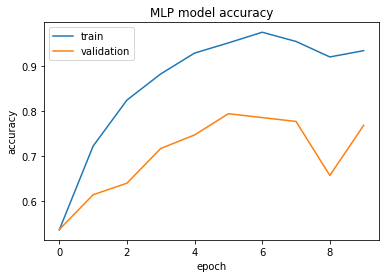

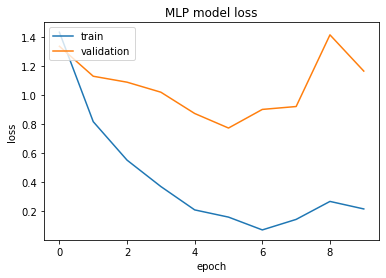

In [23]:
plot_history = visualization.classifier_history (history, 'MLP ')

mean accuracy score: 0.78


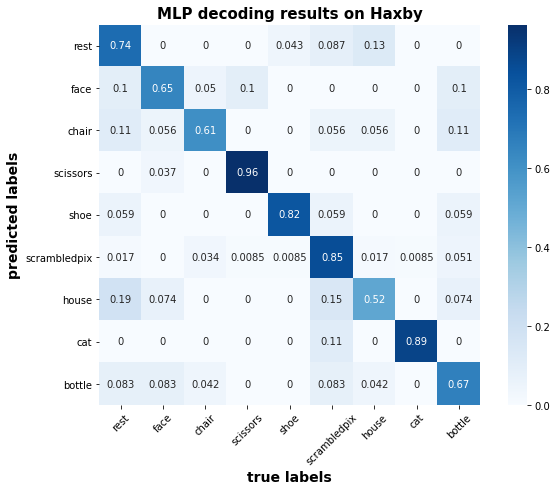

In [24]:
# Making the predictions and evaluating the model
y_pred = mlp_classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print ('mean accuracy score:', np.round(accuracy_score(y_test.values.argmax(axis = 1), 
                                                       y_pred.argmax(axis=1), normalize = True, 
                                                       sample_weight=None),2))

# Confusion matrix
cm_mlp = confusion_matrix(y_test.values.argmax(axis = 1), y_pred.argmax(axis=1))
model_conf_matrix = cm_mlp.astype('float') / cm_mlp.sum(axis = 1)[:, np.newaxis]

visualization.conf_matrix(model_conf_matrix, 
                          categories, 
                          title='MLP decoding results on Haxby')